# Tiny ImageNet

Tiny ImageNet is a smaller subset of the ImageNet dataset designed for quick prototyping and experimentation. It is widely used in deep learning research and education due to its manageable size and complexity.

## Key Features
- **Number of Classes**: 200 classes, each corresponding to a specific object category.
- **Image Size**: All images are resized to 64x64 pixels, making it computationally efficient to train models.
- **Dataset Structure**:
  - **Training Set**: 100,000 images (500 per class).
  - **Validation Set**: 10,000 images (50 per class).
  - **Test Set**: 10,000 images (unlabeled).


## Dataset Organization
Tiny ImageNet is organized into folders:
- `train/`: Contains subfolders for each class with images for training.
- `val/`: Contains validation images and a CSV file `val_annotations.txt` with image-label mappings.
- `test/`: Contains test images (no labels provided).


https://www.kaggle.com/c/tiny-imagenet

In [1]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.keras.backend as K
import itertools
from functools import partial

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
RANDOM_SEED = 42
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 128

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0].name}")
else:
    print("No GPU found. TensorFlow is running on the CPU.")

Num GPUs Available:  1
TensorFlow is using GPU: /physical_device:GPU:0


In [4]:
default_path = "tiny-imagenet-200"
path_to_train_files = default_path + "/train"  # kaggle: "../input/tiny-imagenet/tiny-imagenet-200/train"
path_to_val_files = default_path + "/val/images" # kaggle: "../input/tiny-imagenet/tiny-imagenet-200/val/images"
path_to_test_files = default_path + "/test/images" # kaggle: "../input/tiny-imagenet/tiny-imagenet-200/test/images"

In [5]:
unique_tiny_labels = os.listdir(path_to_train_files)

In [6]:
unique_labels = pd.read_csv(default_path + "/words.txt", sep='\t', 
                header=None, names=["class_id", "label"])
unique_labels.class_id = unique_labels.class_id.astype(str)
unique_labels = unique_labels.loc[unique_labels['class_id'].isin(unique_tiny_labels)]
unique_labels.sort_values(by="label", inplace=True)
unique_labels.reset_index(inplace=True, drop=True)
unique_labels = tf.convert_to_tensor(unique_labels)

In [7]:
train_files_pattern = os.path.join(path_to_train_files, '*', 'images', '*.JPEG')
train_ds_files = tf.data.Dataset.list_files(train_files_pattern, shuffle=True, seed=RANDOM_SEED)

In [8]:
val_files_pattern = os.path.join(path_to_val_files, '*.JPEG')
test_files_pattern = os.path.join(path_to_test_files, '*.JPEG')

val_ds_files = tf.data.Dataset.list_files(val_files_pattern)
test_ds = tf.data.Dataset.list_files(test_files_pattern)

In [9]:
val_labels = pd.read_csv(default_path + "/val/val_annotations.txt",  sep='\t', 
                header=None, names=["file_name", "class_id", "box_coord_1", "box_coord_2", "box_coord_3", "box_coord_4"])

In [10]:
val_labels = tf.convert_to_tensor(val_labels[["file_name", "class_id"]])

In [11]:
@tf.function
def load_image(filename, is_train_ds=True, scaled_version=True):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    
    if scaled_version:
        image = tf.image.convert_image_dtype(image, tf.float32)
        
    parts = tf.strings.split(filename, os.sep)

    if is_train_ds:
        label = parts[-3]  
    else:
        file_basename = parts[-1]  
        label = val_labels[tf.argmax(tf.equal(val_labels[:, 0], file_basename)), 1]
        
    #label = unique_labels[tf.argmax(tf.equal(unique_labels[:, 0], label)), 1] # if string label
    label = tf.argmax(tf.equal(unique_labels[:, 0], label)) # if as int
    
    return image, label

In [12]:
@tf.function
def apply_data_augmentation(image, label, scale_mode='0_1',  augmentation_type=None):

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    
    if augmentation_type == 'randaugment':
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        
        max_shift = 4
        image = tf.image.resize_with_crop_or_pad(image, IMG_HEIGHT + max_shift, IMG_WIDTH + max_shift)
        image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    if scale_mode == '0_1':
        image = tf.cast(image, tf.float32)
        image = tf.clip_by_value(image, 0.0, 1.0)
    else:
        image = tf.clip_by_value(image * 255, 0, 255)
        image = tf.round(image)
        image = tf.cast(image, tf.uint8)

    return image, label

In [13]:
def configure_performance(ds, is_train_ds=True, scale_mode="0_1", augmentation_type=None):
    if is_train_ds:
        ds = ds.cache()
        ds = ds.shuffle(1000)
        ds = ds.map(lambda img, label: apply_data_augmentation(img, label, scale_mode=scale_mode, augmentation_type=augmentation_type), 
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:
        ds = ds.cache()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [14]:
train_ds = configure_performance(train_ds_files.map(lambda fname: load_image(fname),num_parallel_calls=tf.data.experimental.AUTOTUNE), is_train_ds=True, scale_mode="0_1", augmentation_type=None)
val_ds = configure_performance(val_ds_files.map(lambda fname: load_image(fname, is_train_ds=False), num_parallel_calls=tf.data.experimental.AUTOTUNE), is_train_ds=False)

train_ds_unscld = configure_performance(train_ds_files.map(lambda fname: load_image(fname, scaled_version=False), num_parallel_calls=tf.data.experimental.AUTOTUNE),  is_train_ds=True, scale_mode="0_255", augmentation_type=None)
val_ds_unscld = configure_performance(val_ds_files.map(lambda fname: load_image(fname, is_train_ds=False, scaled_version=False), num_parallel_calls=tf.data.experimental.AUTOTUNE), is_train_ds=False)

In [15]:
image_batch, labels_batch = next(iter(train_ds))

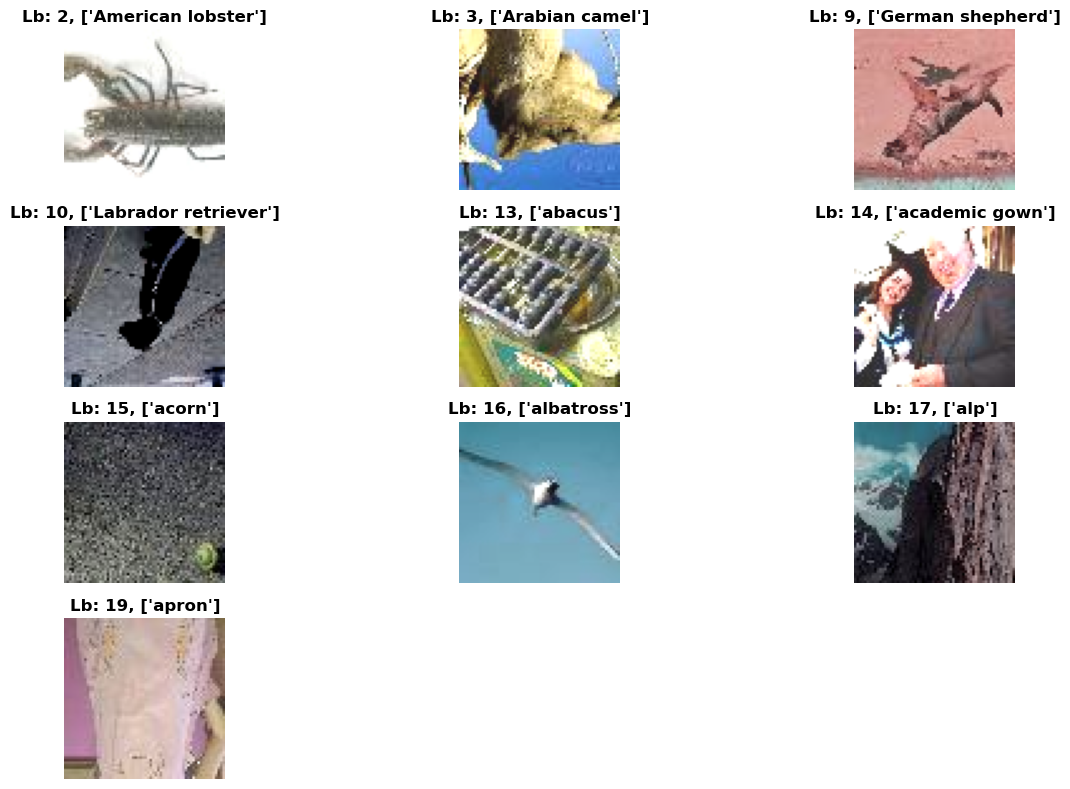

In [18]:
plt.figure(figsize=(12, 8))

for idx, label in enumerate(np.unique(labels_batch.numpy().astype(int).tolist())[:10]):
  ax = plt.subplot(4, 3, idx + 1)
  label_idx = tf.argmax(labels_batch.numpy() == label).numpy()
  plt.imshow(image_batch[label_idx])
  plt.title(f"Lb: {label}, {unique_labels[label].numpy()[1].decode('utf-8').split(',')[0:1]}", fontweight="bold")
  plt.axis("off")

plt.tight_layout()
plt.show()

## Using a State-of-Art CNN Architecture

ConvNext V1:
https://arxiv.org/pdf/2201.03545

ConvNext V2:
https://arxiv.org/pdf/2301.00808


## Steps:

1. FCMAE on Tiny-Imagenet:

    Masked Autoencoder model pretrain to transform masked images (40-60%) to original to learn patterns.

2. Fine-tune on Tiny-Imagenet:

    Fine-tune the model with a different head, categorical cross-entropy, softmax.
3. Cross-Validation:

    On n different folds

In [17]:
import math

In [45]:
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecay 
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule for custom scheduling

class WarmupCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_target, warmup_steps, decay_steps, alpha=0.0):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_target = warmup_target
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        self.alpha = alpha

    def __call__(self, step):
        warmup_lr = self.initial_learning_rate + (self.warmup_target - self.initial_learning_rate) * (step / self.warmup_steps)
        
        step_cosine = step - self.warmup_steps
        decay_steps_adjusted = self.decay_steps - self.warmup_steps
        cosine_decay = 0.5 * (1 + tf.cos(tf.constant(math.pi) * step_cosine / decay_steps_adjusted))
        decayed_lr = (1 - self.alpha) * cosine_decay + self.alpha
        decayed_lr = self.warmup_target * decayed_lr

        return tf.cond(
            step < self.warmup_steps,
            lambda: warmup_lr,
            lambda: decayed_lr
        )

In [47]:
# Global Response Normalization (GRN)
class GlobalResponseNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-6):
        super(GlobalResponseNormalization, self).__init__()
        self.epsilon = epsilon

    def call(self, x):
        gx = tf.reduce_mean(tf.square(x), axis=[1, 2], keepdims=True)
        gx = tf.math.rsqrt(gx + self.epsilon)
        return x * gx

In [48]:
# ConvNeXt V2 Block with GRN
class ConvNeXtBlock(tf.keras.layers.Layer):
    def __init__(self, dim, drop_path=0.0):
        super(ConvNeXtBlock, self).__init__()
        self.dwconv = tf.keras.layers.DepthwiseConv2D(kernel_size=7, padding='same')
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.pwconv1 = tf.keras.layers.Dense(4 * dim)
        self.gelu = tf.keras.layers.Activation('gelu')
        self.grn = GlobalResponseNormalization()
        self.pwconv2 = tf.keras.layers.Dense(dim)
        self.drop_path = tf.keras.layers.Dropout(drop_path) if drop_path > 0 else tf.identity

    def call(self, x, training=False):
        residual = x
        x = self.dwconv(x)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.gelu(x)
        x = self.grn(x)
        x = self.pwconv2(x)
        x = self.drop_path(x, training=training)
        return residual + x

In [49]:
# Downsampling Layer
class DownsampleBlock(tf.keras.layers.Layer):
    def __init__(self, out_channels):
        super(DownsampleBlock, self).__init__()
        self.downsample = tf.keras.layers.Conv2D(out_channels, kernel_size=2, strides=2, padding='same')
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, x):
        x = self.downsample(x)
        x = self.norm(x)
        return x

In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),

    tf.keras.layers.Conv2D(96, kernel_size=4, strides=4, padding='same'),
    tf.keras.layers.LayerNormalization(epsilon=1e-6),
    ConvNeXtBlock(dim=96, drop_path=0.1),
    ConvNeXtBlock(dim=96, drop_path=0.1),
    ConvNeXtBlock(dim=96, drop_path=0.1),
    DownsampleBlock(out_channels=192),

    ConvNeXtBlock(dim=192, drop_path=0.1),
    ConvNeXtBlock(dim=192, drop_path=0.1),
    ConvNeXtBlock(dim=192, drop_path=0.1),
    ConvNeXtBlock(dim=192, drop_path=0.1),
    DownsampleBlock(out_channels=384),

    ConvNeXtBlock(dim=384, drop_path=0.2),
    ConvNeXtBlock(dim=384, drop_path=0.2),
    ConvNeXtBlock(dim=384, drop_path=0.2),
    ConvNeXtBlock(dim=384, drop_path=0.2),
    DownsampleBlock(out_channels=768),

    ConvNeXtBlock(dim=768, drop_path=0.2),
    ConvNeXtBlock(dim=768, drop_path=0.2),
    ConvNeXtBlock(dim=768, drop_path=0.2),
    ConvNeXtBlock(dim=768, drop_path=0.2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.LayerNormalization(epsilon=1e-6),
    tf.keras.layers.Dense(128, activation='gelu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(200, activation='softmax')
])

In [51]:
lr_schedule = WarmupCosineDecay(
    initial_learning_rate=1e-5,
    warmup_target=0.001,
    warmup_steps=5000,
    decay_steps=62500,
    alpha=0.0
)

In [52]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
)

# Cross-validation on 3 StratifiedKFold